In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import glob # Import glob for finding files

# Configurações gerais
EPOCHS = 200
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {DEVICE}")

# Caminho para o dataset "Doencas-Olhos"
DATA_DIR = 'datasetsTCC/Doencas-Olhos'

# 1. Definir as transformações da imagem
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 2. Criar um Dataset customizado para carregar todas as imagens recursivamente
class AllImagesDataset(Dataset):
    def __init__(self, root_dir, transform=None): # Corrected argument name to root_dir
        self.root_dir = root_dir
        self.transform = transform
        # Find all image files (jpg, jpeg, png) recursively
        self.image_files = glob.glob(os.path.join(self.root_dir, '**', '*.jpg'), recursive=True) + \
                           glob.glob(os.path.join(self.root_dir, '**', '*.jpeg'), recursive=True) + \
                           glob.glob(os.path.join(self.root_dir, '**', '*.png'), recursive=True)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB') # Open as RGB first to handle different formats

        if self.transform:
            image = self.transform(image)

        return image, 0 # Return image and a dummy label (0) as we don't have class info here

# Carregar o dataset usando o Dataset customizado
# Como não estamos separando treino e teste explicitamente nesta abordagem,
# vamos carregar todas as imagens e depois splitar manualmente se necessário
full_dataset = AllImagesDataset(root_dir=DATA_DIR, transform=transform) # Corrected argument name to root_dir

# Split dataset into train and test (optional, depending on model training needs)
# For autoencoders, often the same data is used for input and target, so a simple split might not be needed
# However, if you want to train on a subset and test on another, uncomment the lines below:
# train_size = int(0.8 * len(full_dataset))
# test_size = len(full_dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# For now, let's use the full dataset for the loader as autoencoders often train on all data
train_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False) # Use full dataset for testing visualization

print(f"Número total de imagens encontradas: {len(full_dataset)}")


# Função para visualizar as imagens
def plot_images(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    # Ensure we don't plot more than available images
    num_images_to_plot = min(n, original.size(0))
    for i in range(num_images_to_plot):
        # Imagem original
        ax = plt.subplot(2, num_images_to_plot, i + 1)
        # Desnormaliza a imagem para o intervalo [0, 1] para exibição
        img = original[i].cpu().numpy().squeeze() * 0.5 + 0.5
        plt.imshow(img, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == num_images_to_plot // 2:
            ax.set_title("Originais")

        # Imagem reconstruída
        ax = plt.subplot(2, num_images_to_plot, i + 1 + num_images_to_plot)
        # Desnormaliza a imagem para o intervalo [0, 1] para exibição
        rec_img = reconstructed[i].cpu().numpy().squeeze() * 0.5 + 0.5
        plt.imshow(rec_img, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == num_images_to_plot // 2:
            ax.set_title("Reconstruídas")
    plt.show()


Usando dispositivo: cpu
Número total de imagens encontradas: 4217


Vanilla AE | Epoch [1/200], Loss: 0.4707
Vanilla AE | Epoch [2/200], Loss: 0.1350
Vanilla AE | Epoch [3/200], Loss: 0.0751
Vanilla AE | Epoch [4/200], Loss: 0.0609
Vanilla AE | Epoch [5/200], Loss: 0.0532
Vanilla AE | Epoch [6/200], Loss: 0.0463
Vanilla AE | Epoch [7/200], Loss: 0.0405
Vanilla AE | Epoch [8/200], Loss: 0.0366
Vanilla AE | Epoch [9/200], Loss: 0.0339
Vanilla AE | Epoch [10/200], Loss: 0.0307
Vanilla AE | Epoch [11/200], Loss: 0.0283
Vanilla AE | Epoch [12/200], Loss: 0.0269
Vanilla AE | Epoch [13/200], Loss: 0.0254
Vanilla AE | Epoch [14/200], Loss: 0.0242
Vanilla AE | Epoch [15/200], Loss: 0.0233
Vanilla AE | Epoch [16/200], Loss: 0.0226
Vanilla AE | Epoch [17/200], Loss: 0.0219
Vanilla AE | Epoch [18/200], Loss: 0.0215
Vanilla AE | Epoch [19/200], Loss: 0.0206
Vanilla AE | Epoch [20/200], Loss: 0.0202
Vanilla AE | Epoch [21/200], Loss: 0.0200
Vanilla AE | Epoch [22/200], Loss: 0.0198
Vanilla AE | Epoch [23/200], Loss: 0.0194
Vanilla AE | Epoch [24/200], Loss: 0.0186
V

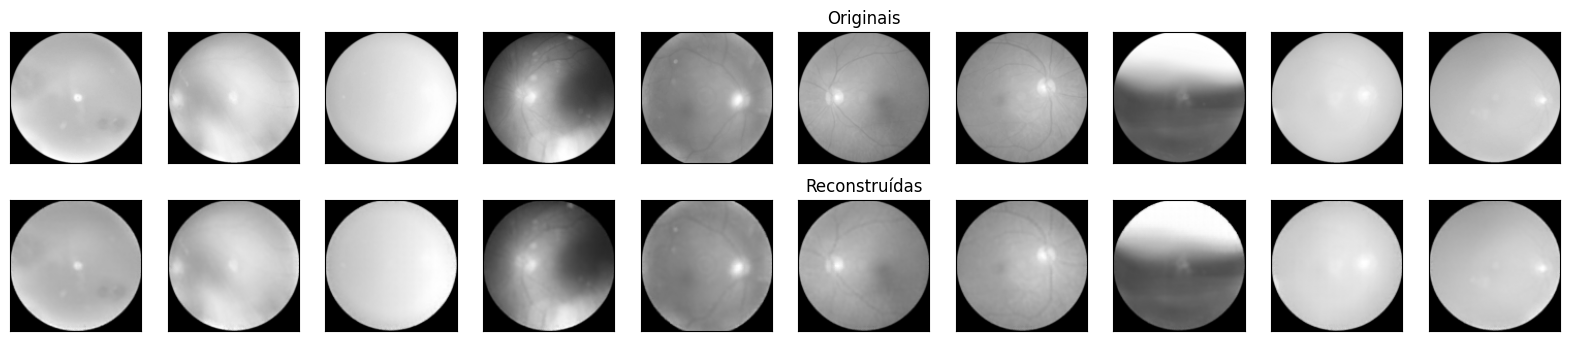

In [33]:
# 1. Definição do Modelo Vanilla Autoencoder
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()

        # Encoder: Reduz a imagem espacialmente e aumenta a profundidade (canais)
        self.encoder = nn.Sequential(
            # Entrada: [N, 1, 128, 128] (N = batch_size)
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),  # -> [N, 16, 64, 64]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # -> [N, 32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # -> [N, 64, 16, 16]
            #nn.ReLU(),
            #nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) # -> [N, 128, 8, 8]
        )

        self.decoder = nn.Sequential(
            # Entrada: [N, 128, 8, 8]
            #nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # -> [N, 64, 16, 16]
            #nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # -> [N, 32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # -> [N, 16, 64, 64]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   # -> [N, 1, 128, 128]
            nn.Tanh() # Escala a saída para [-1, 1], igual à normalização da entrada
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 2. Treinamento do Modelo
model_vanilla = ConvolutionalAutoencoder().to(DEVICE)
criterion = nn.L1Loss()
optimizer = optim.Adam(model_vanilla.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    total_loss = 0
    for data in train_loader:
        images, _ = data
        images = images.to(DEVICE)

        outputs = model_vanilla(images)

        # Achatamos as imagens originais para calcular a perda com a saída achatada do decoder
        # (O modelo já remodela a saída, então comparamos imagens com imagens)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Vanilla AE | Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss/len(train_loader):.4f}")

# 3. Visualização dos Resultados
print("\n--- Visualizando resultados do Vanilla Autoencoder ---")
with torch.no_grad():
    data_iter = iter(test_loader)
    test_images, _ = next(data_iter)
    test_images = test_images.to(DEVICE)

    reconstructed_images = model_vanilla(test_images)
    plot_images(test_images, reconstructed_images)

Autoencoder Esparso

Sparse AE | Epoch [1/200], Loss: 0.9709, Recon: 0.4573, Sparsity: 10.2707
Sparse AE | Epoch [2/200], Loss: 0.2096, Recon: 0.2043, Sparsity: 0.1066
Sparse AE | Epoch [3/200], Loss: 0.1377, Recon: 0.1356, Sparsity: 0.0425
Sparse AE | Epoch [4/200], Loss: 0.1103, Recon: 0.1095, Sparsity: 0.0169
Sparse AE | Epoch [5/200], Loss: 0.0927, Recon: 0.0916, Sparsity: 0.0218
Sparse AE | Epoch [6/200], Loss: 0.0760, Recon: 0.0755, Sparsity: 0.0106
Sparse AE | Epoch [7/200], Loss: 0.0638, Recon: 0.0626, Sparsity: 0.0242
Sparse AE | Epoch [8/200], Loss: 0.0583, Recon: 0.0572, Sparsity: 0.0220
Sparse AE | Epoch [9/200], Loss: 0.0536, Recon: 0.0526, Sparsity: 0.0206
Sparse AE | Epoch [10/200], Loss: 0.0493, Recon: 0.0484, Sparsity: 0.0177
Sparse AE | Epoch [11/200], Loss: 0.0471, Recon: 0.0464, Sparsity: 0.0150
Sparse AE | Epoch [12/200], Loss: 0.0435, Recon: 0.0429, Sparsity: 0.0130
Sparse AE | Epoch [13/200], Loss: 0.0410, Recon: 0.0404, Sparsity: 0.0113
Sparse AE | Epoch [14/200], Loss: 0.0389, Reco

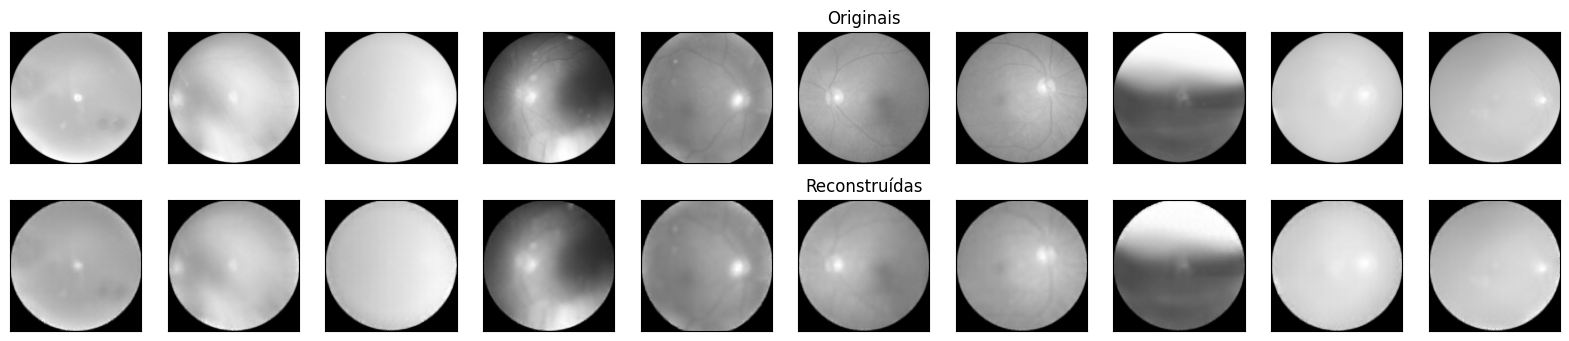

In [5]:
def kl_divergence_sparsity(rho, rho_hat):
    """
    Calcula a Divergência KL para a penalidade de esparsidade.
    rho: Parâmetro de esparsidade desejado (um escalar).
    rho_hat: Ativação da camada oculta (um tensor no formato [N, C, H, W]).
    """
    # Primeiro, aplicamos sigmoid para colocar as ativações entre 0 e 1
    activations = torch.sigmoid(rho_hat)

    # Média sobre o batch (dim 0), altura (dim 2) e largura (dim 3)
    avg_activations = activations.mean(dim=(0, 2, 3))

    # Adiciona um pequeno epsilon para estabilidade numérica
    avg_activations = torch.clamp(avg_activations, 1e-6, 1 - 1e-6)

    # Fórmula da Divergência KL. Agora ela opera em um vetor de médias [C].
    kl_div = rho * torch.log(rho / avg_activations) + (1 - rho) * torch.log((1 - rho) / (1 - avg_activations))

    # Retornamos a soma da penalidade sobre todos os canais
    return torch.sum(kl_div)

# --- 2. DEFINIÇÃO DO MODELO (MODIFICADO PARA CLAREZA) ---
# A arquitetura é a mesma, mas separamos 'encode' e 'decode' para facilitar o acesso às ativações
class SparseAutoencoder(nn.Module):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            # Entrada: [N, 1, 128, 128] (N = batch_size)
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),  # -> [N, 16, 64, 64]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # -> [N, 32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # -> [N, 64, 16, 16]
            #nn.ReLU(),
            #nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) # -> [N, 128, 8, 8]
        )

        self.decoder = nn.Sequential(
            # Entrada: [N, 128, 8, 8]
            #nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # -> [N, 64, 16, 16]
            #nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # -> [N, 32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # -> [N, 16, 64, 64]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   # -> [N, 1, 128, 128]
            nn.Tanh()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded

# --- 3. TREINAMENTO DO MODELO ESPARSO ---
# MUDANÇA: Adicionamos hiperparâmetros para a esparsidade
SPARSITY_TARGET = 0.05  # rho: Queremos que cada neurônio ative em média 5% do tempo
SPARSITY_WEIGHT = 5e-2  # lambda: O peso/força da penalidade de esparsidade

model_sparse = SparseAutoencoder().to(DEVICE)
criterion = nn.L1Loss()
optimizer = optim.Adam(model_sparse.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    total_loss = 0
    total_recon_loss = 0
    total_sparsity_loss = 0

    for data in train_loader:
        images, _ = data
        images = images.to(DEVICE)

        # MUDANÇA: Separamos a passagem pelo encoder e decoder
        encoded_activations = model_sparse.encode(images)
        outputs = model_sparse.decode(encoded_activations)

        # MUDANÇA: Calculamos as duas partes da perda
        recon_loss = criterion(outputs, images)
        sparsity_loss = kl_divergence_sparsity(SPARSITY_TARGET, encoded_activations)

        # A perda total é a soma da reconstrução com a penalidade de esparsidade
        loss = recon_loss + SPARSITY_WEIGHT * sparsity_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_sparsity_loss += sparsity_loss.item()

    # MUDANÇA: Print mais detalhado para monitorar as perdas
    avg_loss = total_loss / len(train_loader)
    avg_recon = total_recon_loss / len(train_loader)
    avg_sparsity = total_sparsity_loss / len(train_loader)
    print(f"Sparse AE | Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, Sparsity: {avg_sparsity:.4f}")

# --- 4. VISUALIZAÇÃO DOS RESULTADOS ---
# Esta parte permanece a mesma, apenas usando o novo modelo treinado
print("\n--- Visualizando resultados do Sparse Autoencoder ---")
model_sparse.eval()
with torch.no_grad():
    data_iter = iter(test_loader)
    test_images, _ = next(data_iter)
    test_images = test_images.to(DEVICE)

    reconstructed_images = model_sparse(test_images)
    plot_images(test_images, reconstructed_images)

Denoising AutoEncoder

Denoising AE | Epoch [1/200], Loss: 0.3194
Denoising AE | Epoch [2/200], Loss: 0.0875
Denoising AE | Epoch [3/200], Loss: 0.0621
Denoising AE | Epoch [4/200], Loss: 0.0493
Denoising AE | Epoch [5/200], Loss: 0.0389
Denoising AE | Epoch [6/200], Loss: 0.0337
Denoising AE | Epoch [7/200], Loss: 0.0296
Denoising AE | Epoch [8/200], Loss: 0.0278
Denoising AE | Epoch [9/200], Loss: 0.0257
Denoising AE | Epoch [10/200], Loss: 0.0243
Denoising AE | Epoch [11/200], Loss: 0.0234
Denoising AE | Epoch [12/200], Loss: 0.0229
Denoising AE | Epoch [13/200], Loss: 0.0217
Denoising AE | Epoch [14/200], Loss: 0.0212
Denoising AE | Epoch [15/200], Loss: 0.0205
Denoising AE | Epoch [16/200], Loss: 0.0204
Denoising AE | Epoch [17/200], Loss: 0.0200
Denoising AE | Epoch [18/200], Loss: 0.0194
Denoising AE | Epoch [19/200], Loss: 0.0195
Denoising AE | Epoch [20/200], Loss: 0.0193
Denoising AE | Epoch [21/200], Loss: 0.0188
Denoising AE | Epoch [22/200], Loss: 0.0187
Denoising AE | Epoch [23/200], Loss: 0.01

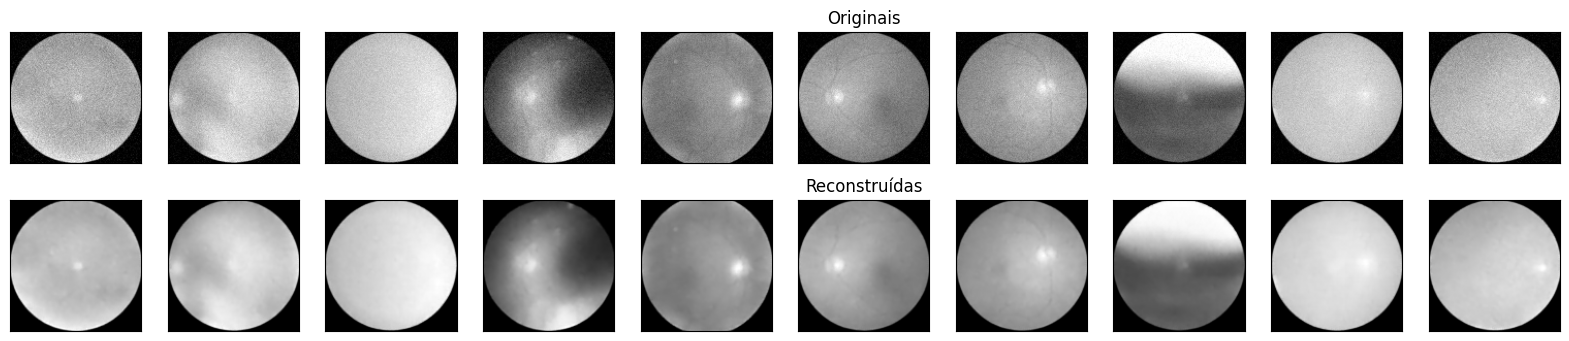

In [8]:
# 1. Definição do Modelo Denoising Autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            #nn.ReLU(),
            #nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        )

        self.decoder = nn.Sequential(
            #nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # -> [N, 64, 16, 16]
            #nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # -> [N, 32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # -> [N, 16, 64, 64]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   # -> [N, 1, 128, 128]
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), 1, 128, 128)
        return decoded

# 2. Treinamento do Modelo
model_denoising = DenoisingAutoencoder().to(DEVICE)
criterion = nn.L1Loss()
optimizer = optim.Adam(model_denoising.parameters(), lr=LEARNING_RATE)
noise_factor = 0.05 # Fator de ruído

for epoch in range(EPOCHS):
    total_loss = 0
    for data in train_loader:
        images, _ = data
        images = images.to(DEVICE)

        # Adicionar ruído às imagens de entrada
        noisy_images = images + noise_factor * torch.randn(*images.shape, device=DEVICE)
        noisy_images = torch.clamp(noisy_images, -1., 1.) # Manter no intervalo [-1, 1]


        outputs = model_denoising(noisy_images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Denoising AE | Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss/len(train_loader):.4f}")

# 3. Visualização dos Resultados
print("\n--- Visualizando resultados do Denoising Autoencoder ---")
with torch.no_grad():
    data_iter = iter(test_loader)
    test_images, _ = next(data_iter)
    test_images = test_images.to(DEVICE)

    # Cria uma versão ruidosa para visualização
    noisy_test_images = test_images + noise_factor * torch.randn(*test_images.shape, device=DEVICE)
    noisy_test_images = torch.clamp(noisy_test_images, -1., 1.)

    reconstructed_images = model_denoising(noisy_test_images)

    plot_images(noisy_test_images, reconstructed_images)